In [1]:
!pip install git+https://github.com/omarcastano/MasterThesis.git
#!git clone https://github.com/omarcastano/MLutilities.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/omarcastano/MasterThesis.git to /tmp/pip-req-build-7f0rop6e
  Running command git clone -q https://github.com/omarcastano/MasterThesis.git /tmp/pip-req-build-7f0rop6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 490 kB 7.4 MB/s 
     |████████████████████████████████| 1.8 MB 17.1 MB/s 
     |████████████████████████████████| 1.4 MB 53.9 MB/s 
     |████████████████████████████████| 708 kB 60.1 MB/s 
     |████████████████████████████████| 1.0 MB 63.9 MB/s 
     |████████████████████████████████| 316 kB 68.4 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 16.7 MB 53.5 MB/s 
     |████████████████████████████████| 6.3 MB 63.3 MB/s 
     |████████████████████████████████| 151 kB 62.9 MB/s 

In [2]:
!nvidia-smi

Thu Oct  6 22:43:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Load libraries
from typing import List, Callable, Union, Tuple
import multiprocessing as mp
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import os
import matplotlib.patches as mpatches
import numpy as np
import torch
from tqdm.autonotebook import tqdm
from IPython.display import clear_output

#custom libary
import MasterThesis.preprocessing as DP
from MasterThesis import EDA
#from MasterThesis.utils import metrics, simclr, data_for_seg
#from MasterThesis.utils import data_for_seg

#import wandB
import wandb
wandb.login(key="ed6b4f7a25cd803c9ce7a66dbfba2353fe5bb5d2")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
drive_path = '/content/drive/MyDrive' 
drive_path = '/mnt/h/Mi unidad'
drive_path="/content"

In [6]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train = np.append(X_train, X_test, axis=0)
y_train = np.append(y_train, y_test, axis=0)

#mask = np.isin(y_train.copy(), [0, 1, 2]).ravel()
#X_train = X_train[mask, :, :, :]
#y_train = y_train[mask, :]

select_classes = {0:"airplane",   
                1:"automobile", 
                2:"bird",       
                3:"cat",        
                4:"deer",      
                5:"dog",        
                6:"frog",       
                7:"horse",      
                8:"ship",       
                9:"truck"}     

path_to_save_images = "/content/Images"
#path_to_save_images = "/content/drive/MyDrive/Maestria/Theses/CIFAR/Images"

import os

if not os.path.isdir("/content/Images"):
    os.mkdir("/content/Images")

for folder in select_classes.values():
    os.mkdir(path_to_save_images + "/" + f"{folder}")

images = []
labels = []
classes = []
for i in tqdm(range(len(X_train))):
    np.savez(f"{path_to_save_images}/{select_classes[y_train[i][0]]}/{i}.npz", X_train[i].transpose(2,0,1))

    images.append(f"{select_classes[y_train[i][0]]}/{i}.npz")
    labels.append(y_train[i][0])
    classes.append(select_classes[y_train[i][0]])


metadata = pd.DataFrame({"Image":images, "Labels":labels, "Classes":classes})
metadata.to_csv("/content/metadata.csv", index=False)
#metadata.to_csv("/content/drive/MyDrive/Maestria/Theses/CIFAR/metadata.csv", index=False)
metadata.head()

170508288/170498071 [==============================] - 14s 0us/step


  0%|          | 0/60000 [00:00<?, ?it/s]

,Image,Labels,Classes
0,frog/0.npz,6,frog
1,truck/1.npz,9,truck
2,truck/2.npz,9,truck
3,deer/3.npz,4,deer
4,automobile/4.npz,1,automobile


In [7]:
#Load metadata
path_to_metadata =  f'{drive_path}/metadata.csv'
metadata = pd.read_csv(path_to_metadata).sample(frac=1, random_state=42)
#metadata = metadata.query("Classes in ['airplane', 'automobile', 'bird']")
print(metadata.shape)
metadata.head()

(60000, 3)


,Image,Labels,Classes
12628,automobile/12628.npz,1,automobile
37730,truck/37730.npz,9,truck
39991,bird/39991.npz,2,bird
8525,ship/8525.npz,8,ship
8279,deer/8279.npz,4,deer


In [8]:
# path to image and masks
path_to_images = f"{drive_path}/Images/"
select_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
#select_classes = ["airplane", "automobile", "bird"]

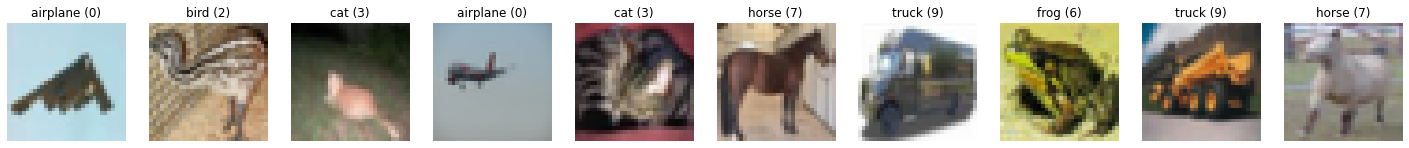

In [9]:
#Plot images
fig = EDA.visualize_images_and_labels(path_to_images, metadata.sample(frac=1), temporal_dim=False, n=10, figsize=(25,7), scale_factor=255)

# Create Datasets

In [10]:
# import libraries
import numpy as np
import pandas as pd
import os
import albumentations as album
from MasterThesis import EDA
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import Module
import torch
from tqdm import tqdm
from typing import List, Union, Tuple
import matplotlib.patches as mpatches

## Data Augmentation

In [11]:
from MasterThesis.utils.classification import randominit

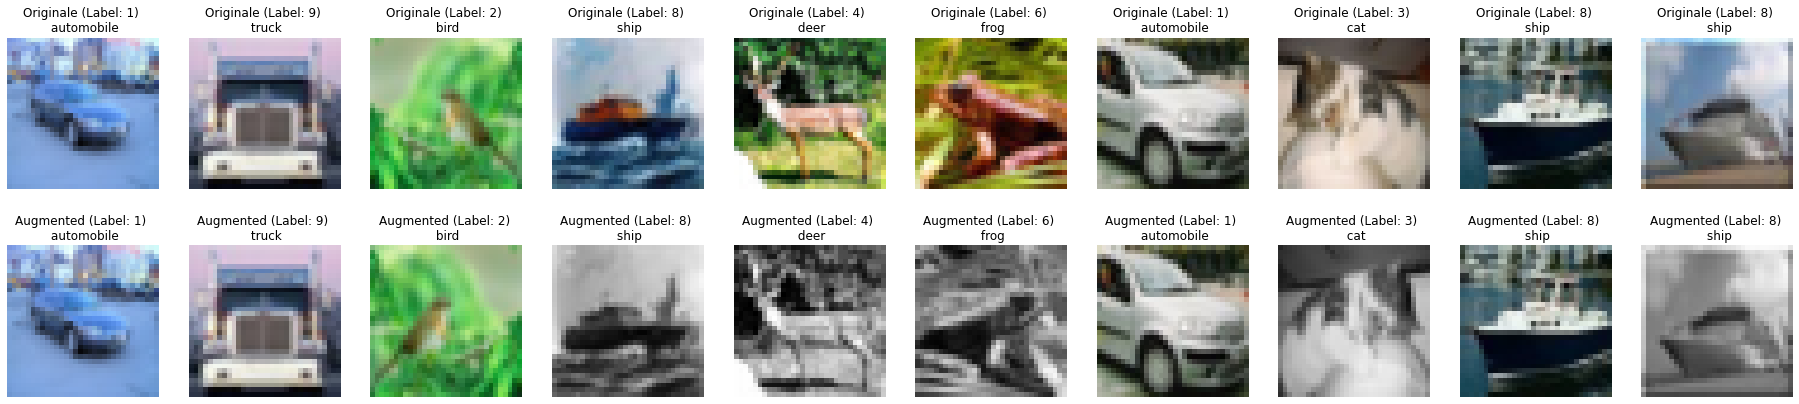

In [12]:
ds = randominit.CustomDataset(path_to_images, metadata, return_original=True, normalizing_factor=255, augmentation=True)
randominit.visualize_augmented_images(ds, classes_name=select_classes)

## Label distribution

In [13]:
px.histogram(data_frame=metadata, x="Classes", histnorm="percent")

# Training

In [14]:
from MasterThesis.utils.classification import randominit

In [15]:
#Torch device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = "cpu"

In [16]:
drive_path = '/content/drive/MyDrive'
path_to_load_backbone = (
    f"/{drive_path}/Maestria/Theses/CIFAR/models/CIFAR10/model_SSL-SimCLR.pth"
)

In [17]:
# Generate metadata to train and test model via cross-cv
train_size = 0.005

metadata_train, metadata_test =randominit.generate_metadata_train_test_stratified_cv(
    metadata, train_size=train_size, n_split=5
)

Number fo total images : 60000
Number of images to train: 300 (0.500%)


In [18]:
px.histogram(data_frame=metadata_train[0], x="Classes")

In [19]:
def run_ss_experiment(train_size = 0.01, backbone_model="SimCLR"):
    # Generate metadata to train and test model via cross-cv

    metadata_train, metadata_test = randominit.generate_metadata_train_test_stratified_cv(
        metadata, train_size=train_size, n_split=5
    )


    hypm = {
        "version": backbone_model,
        "pretrained": backbone_model, # SSL methodology. If not None path_to_load_backbone must be provided
        "fine_tune": True, # wheter or not to fine tune the the whole model (including the pre-trained backbone)
        "ft_epoch": 70, # epoch from which the frozen backbone will be unfreez
        "lr_ft": 0.000005,
        "amount_of_ft_data": train_size,
        "backbone": "resnet18", #Backbone architecture to extrac features
        "classifier":"linear",
        "cifar":True,
        "classifier":"non_linear",
        "input_shape": [32, 32],
        "num_classes":10, # Hyperparameter of deepla model
        "in_channels": 3, # Hyperparameter of deepla model
        "normalizing_factor": 255,
        "weight_decay": 0.00005, # Hyperparameter of Adam optimizer
        "learning_rate": 1e-4, # Hyperparameter of Adam optimizer
        "batch_size": 16,  # Hyperparameter of deepla model
        "epochs": 100,  # Hyperparameter of deepla model
    }

    wandb_kwargs = {
        "project": "CLF_CIFAR3",
        "entity": "omar_castano",
        "config": hypm,
        "id": None,
        "name": backbone_model, # This parameter is also used to identify the saved model
        "resume": False,
    }

    for i in range(5):
        fig = px.histogram(data_frame=metadata_train[i], x="Classes", histnorm="percent")
        fig.show()
        metadata_kwargs = {
            "path_to_images": path_to_images,# Path to images
            "path_to_save_model": None,  # Path to save the model that is being trained
            "path_to_load_model": None,  # Path to load a model from a checkpoint (useful to handle notebook disconection)
            "path_to_load_backbone": path_to_load_backbone,  # Path to load a pre-trained backbone using ssl
            "metadata": metadata, # Dataframe with metadata to load images and labels
            "metadata_train": metadata_train[i], # Dataframe with metadata to load images and labels
            "metadata_test": metadata_test[i], # Dataframe with metadata to load images and labels
            "select_classes": select_classes,# List with the unique classes
            "device" : device, # device to train  de DeepLearning model
        }

        randominit.run_train(wandb, wandb_kwargs, metadata_kwargs)

        if i == 1:
            break

In [20]:
def run_randominit_experiment(train_size=0.01):
    # Generate metadata to train and test model via cross-cv

    metadata_train, metadata_test = randominit.generate_metadata_train_test_stratified_cv(
        metadata, train_size=train_size, n_split=5
    )
    
    hypm = {
        "version": "RandomInit",
        "pretrained": None,  # SSL methodology. If not None path_to_load_backbone must be provided
        "fine_tune": False,  # wheter or not to fine tune the the whole model (including the pre-trained backbone)
        "ft_epoch": None,  # epoch from which the frozen backbone will be unfreez
        "amount_of_ft_data": train_size,
        "backbone": "resnet18", #Backbone architecture to extrac features
        "cifar":True,
        "classifier":"linear",
        "input_shape": [32, 32],
        "num_classes":10, # Hyperparameter of deepla model
        "in_channels": 3, # Hyperparameter of deepla model
        "normalizing_factor": 255,
        "weight_decay": 0.00005, # Hyperparameter of Adam optimizer
        "learning_rate": 1e-4, # Hyperparameter of Adam optimizer
        "batch_size": 16,  # Hyperparameter of deepla model
        "epochs": 100,  # Hyperparameter of deepla model
    }

    wandb_kwargs = {
        "project": "CLF_CIFAR3",
        "entity": "omar_castano",
        "config": hypm,
        "id": None,
        "name": "RandomInit",  # This parameter is also used to identify the saved model
        "resume": False,
    }

    for i in range(5):
        metadata_kwargs = {
            "path_to_images": path_to_images,  # Path to images
            "path_to_save_model": None,  # Path to save the model that is being trained
            "path_to_load_model": None,  # Path to load a model from a checkpoint (useful to handle notebook disconection)
            "path_to_load_backbone": None,  # Path to load a pre-trained backbone using ssl
            "metadata": metadata,  # Dataframe with metadata to load images and labels
            "metadata_train": metadata_train[i],  # Dataframe with metadata to load images and labels
            "metadata_test": metadata_test[i],  # Dataframe with metadata to load images and labels
            "select_classes": select_classes,  # List with the unique classes
            "device": device,  # device to train  de DeepLearning model
        }

        randominit.run_train(wandb, wandb_kwargs, metadata_kwargs)
        if i == 1:
            break

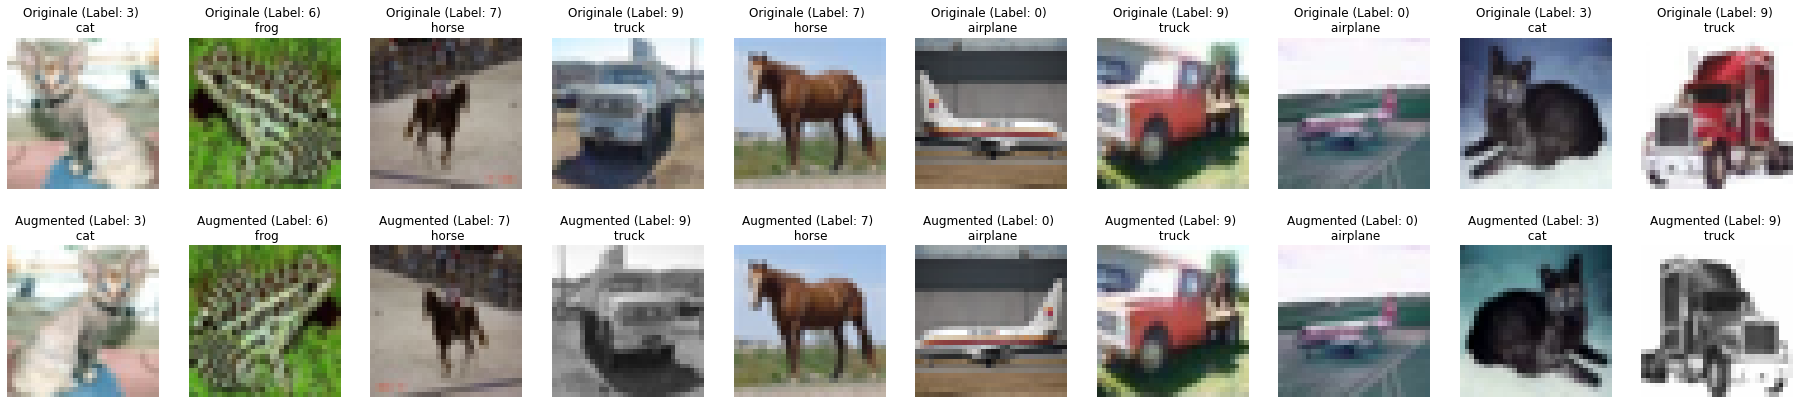

-------------------------------------------------------------
Epoch 1/100


100%|██████████| 750/750 [00:12<00:00, 61.55it/s]



    Train Loss: 18.7854

    Test Loss: 18.2088
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 2/100


100%|██████████| 750/750 [00:12<00:00, 60.81it/s]



    Train Loss: 12.7205

    Test Loss: 12.2747
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 3/100


100%|██████████| 750/750 [00:12<00:00, 60.46it/s]



    Train Loss: 8.4185

    Test Loss: 8.199
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 4/100


100%|██████████| 750/750 [00:12<00:00, 59.85it/s]



    Train Loss: 5.7644

    Test Loss: 5.7119
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 5/100


100%|██████████| 750/750 [00:12<00:00, 60.38it/s]



    Train Loss: 4.2081

    Test Loss: 4.407
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 6/100


100%|██████████| 750/750 [00:12<00:00, 60.72it/s]



    Train Loss: 3.3292

    Test Loss: 4.0782
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 7/100


100%|██████████| 750/750 [00:14<00:00, 50.98it/s]



    Train Loss: 2.6871

    Test Loss: 3.3491
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 8/100


100%|██████████| 750/750 [00:12<00:00, 61.30it/s]



    Train Loss: 2.1928

    Test Loss: 3.0511
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 9/100


100%|██████████| 750/750 [00:12<00:00, 61.07it/s]



    Train Loss: 1.9827

    Test Loss: 3.126
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 10/100


100%|██████████| 750/750 [00:12<00:00, 60.89it/s]



    Train Loss: 1.7544

    Test Loss: 2.9126
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 11/100


100%|██████████| 750/750 [00:12<00:00, 60.55it/s]



    Train Loss: 1.5958

    Test Loss: 2.9393
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 12/100


100%|██████████| 750/750 [00:12<00:00, 60.19it/s]



    Train Loss: 1.5878

    Test Loss: 2.7059
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 13/100


100%|██████████| 750/750 [00:12<00:00, 60.49it/s]



    Train Loss: 1.5248

    Test Loss: 2.638
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 14/100


100%|██████████| 750/750 [00:12<00:00, 61.21it/s]



    Train Loss: 1.5197

    Test Loss: 2.8851
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 15/100


100%|██████████| 750/750 [00:12<00:00, 61.24it/s]



    Train Loss: 1.3909

    Test Loss: 2.8676
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 16/100


100%|██████████| 750/750 [00:12<00:00, 60.85it/s]



    Train Loss: 1.5038

    Test Loss: 2.7767
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 17/100


100%|██████████| 750/750 [00:14<00:00, 51.17it/s]



    Train Loss: 1.366

    Test Loss: 2.6247
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 18/100


100%|██████████| 750/750 [00:12<00:00, 61.60it/s]



    Train Loss: 1.3161

    Test Loss: 2.5227
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 19/100


100%|██████████| 750/750 [00:12<00:00, 61.58it/s]



    Train Loss: 1.2434

    Test Loss: 2.5686
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 20/100


100%|██████████| 750/750 [00:12<00:00, 61.42it/s]



    Train Loss: 1.2106

    Test Loss: 2.6369
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 21/100


100%|██████████| 750/750 [00:12<00:00, 61.49it/s]



    Train Loss: 1.0676

    Test Loss: 2.5029
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 22/100


100%|██████████| 750/750 [00:12<00:00, 61.25it/s]



    Train Loss: 1.0508

    Test Loss: 2.506
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 23/100


100%|██████████| 750/750 [00:12<00:00, 61.16it/s]



    Train Loss: 0.9971

    Test Loss: 2.4276
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 24/100


100%|██████████| 750/750 [00:12<00:00, 61.48it/s]



    Train Loss: 0.9466

    Test Loss: 2.4449
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 25/100


100%|██████████| 750/750 [00:12<00:00, 60.78it/s]



    Train Loss: 0.8777

    Test Loss: 2.4499
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 26/100


100%|██████████| 750/750 [00:14<00:00, 52.99it/s]



    Train Loss: 0.813

    Test Loss: 2.5131
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 27/100


100%|██████████| 750/750 [00:12<00:00, 60.70it/s]



    Train Loss: 0.7304

    Test Loss: 2.4718
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 28/100


100%|██████████| 750/750 [00:12<00:00, 60.97it/s]



    Train Loss: 0.7736

    Test Loss: 2.4769
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 29/100


100%|██████████| 750/750 [00:12<00:00, 61.75it/s]



    Train Loss: 0.7194

    Test Loss: 2.4958
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 30/100


100%|██████████| 750/750 [00:12<00:00, 61.16it/s]



    Train Loss: 0.6961

    Test Loss: 2.5266
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 31/100


100%|██████████| 750/750 [00:12<00:00, 60.86it/s]



    Train Loss: 0.6741

    Test Loss: 2.519
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 32/100


100%|██████████| 750/750 [00:12<00:00, 60.74it/s]



    Train Loss: 0.5786

    Test Loss: 2.5631
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 33/100


100%|██████████| 750/750 [00:12<00:00, 60.74it/s]



    Train Loss: 0.6302

    Test Loss: 2.5498
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 34/100


100%|██████████| 750/750 [00:12<00:00, 60.88it/s]



    Train Loss: 0.4918

    Test Loss: 2.5774
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 35/100


100%|██████████| 750/750 [00:12<00:00, 60.43it/s]



    Train Loss: 0.5086

    Test Loss: 2.5054
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 36/100


100%|██████████| 750/750 [00:14<00:00, 51.03it/s]



    Train Loss: 0.3927

    Test Loss: 2.5026
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 37/100


100%|██████████| 750/750 [00:12<00:00, 61.17it/s]



    Train Loss: 0.458

    Test Loss: 2.501
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 38/100


100%|██████████| 750/750 [00:12<00:00, 61.40it/s]



    Train Loss: 0.3913

    Test Loss: 2.538
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 39/100


100%|██████████| 750/750 [00:12<00:00, 60.88it/s]



    Train Loss: 0.4118

    Test Loss: 2.5635
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 40/100


100%|██████████| 750/750 [00:12<00:00, 60.86it/s]



    Train Loss: 0.3109

    Test Loss: 2.5716
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 41/100


100%|██████████| 750/750 [00:12<00:00, 60.85it/s]



    Train Loss: 0.3506

    Test Loss: 2.6403
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 42/100


100%|██████████| 750/750 [00:12<00:00, 61.19it/s]



    Train Loss: 0.2874

    Test Loss: 2.6586
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 43/100


100%|██████████| 750/750 [00:12<00:00, 61.35it/s]



    Train Loss: 0.2745

    Test Loss: 2.6
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 44/100


100%|██████████| 750/750 [00:12<00:00, 60.89it/s]



    Train Loss: 0.2908

    Test Loss: 2.5725
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 45/100


100%|██████████| 750/750 [00:12<00:00, 60.90it/s]



    Train Loss: 0.2539

    Test Loss: 2.5762
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 46/100


100%|██████████| 750/750 [00:13<00:00, 53.61it/s]



    Train Loss: 0.3166

    Test Loss: 2.5814
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 47/100


100%|██████████| 750/750 [00:12<00:00, 60.90it/s]



    Train Loss: 0.2772

    Test Loss: 2.6079
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 48/100


100%|██████████| 750/750 [00:12<00:00, 60.19it/s]



    Train Loss: 0.2271

    Test Loss: 2.6044
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 49/100


100%|██████████| 750/750 [00:12<00:00, 61.09it/s]



    Train Loss: 0.1958

    Test Loss: 2.624
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 50/100


100%|██████████| 750/750 [00:12<00:00, 61.11it/s]



    Train Loss: 0.1526

    Test Loss: 2.6224
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 51/100


100%|██████████| 750/750 [00:12<00:00, 60.89it/s]



    Train Loss: 0.1858

    Test Loss: 2.6355
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 52/100


100%|██████████| 750/750 [00:12<00:00, 61.26it/s]



    Train Loss: 0.2036

    Test Loss: 2.6469
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 53/100


100%|██████████| 750/750 [00:12<00:00, 60.93it/s]



    Train Loss: 0.2361

    Test Loss: 2.7043
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 54/100


100%|██████████| 750/750 [00:12<00:00, 61.46it/s]



    Train Loss: 0.1243

    Test Loss: 2.7206
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 55/100


100%|██████████| 750/750 [00:14<00:00, 50.22it/s]



    Train Loss: 0.1836

    Test Loss: 2.7741
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 56/100


100%|██████████| 750/750 [00:12<00:00, 61.33it/s]



    Train Loss: 0.1929

    Test Loss: 2.7961
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 57/100


100%|██████████| 750/750 [00:12<00:00, 60.86it/s]



    Train Loss: 0.1511

    Test Loss: 2.7824
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 58/100


100%|██████████| 750/750 [00:12<00:00, 60.08it/s]



    Train Loss: 0.1682

    Test Loss: 2.7511
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 59/100


100%|██████████| 750/750 [00:12<00:00, 60.93it/s]



    Train Loss: 0.1497

    Test Loss: 2.7834
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 60/100


100%|██████████| 750/750 [00:12<00:00, 60.98it/s]



    Train Loss: 0.1254

    Test Loss: 2.8768
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 61/100


100%|██████████| 750/750 [00:12<00:00, 60.00it/s]



    Train Loss: 0.1671

    Test Loss: 2.8025
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 62/100


100%|██████████| 750/750 [00:12<00:00, 60.26it/s]



    Train Loss: 0.1384

    Test Loss: 2.8214
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 63/100


100%|██████████| 750/750 [00:12<00:00, 60.62it/s]



    Train Loss: 0.1084

    Test Loss: 2.7858
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 64/100


100%|██████████| 750/750 [00:12<00:00, 60.60it/s]



    Train Loss: 0.1023

    Test Loss: 2.7938
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 65/100


100%|██████████| 750/750 [00:14<00:00, 51.56it/s]



    Train Loss: 0.1551

    Test Loss: 2.8211
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 66/100


100%|██████████| 750/750 [00:12<00:00, 61.06it/s]



    Train Loss: 0.1199

    Test Loss: 2.751
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 67/100


100%|██████████| 750/750 [00:12<00:00, 60.37it/s]



    Train Loss: 0.127

    Test Loss: 2.7832
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 68/100


100%|██████████| 750/750 [00:12<00:00, 61.27it/s]



    Train Loss: 0.104

    Test Loss: 2.7756
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 69/100


100%|██████████| 750/750 [00:12<00:00, 61.01it/s]



    Train Loss: 0.0905

    Test Loss: 2.7876
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 70/100


100%|██████████| 750/750 [00:12<00:00, 61.04it/s]



    Train Loss: 0.1227

    Test Loss: 2.7432
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 71/100


100%|██████████| 750/750 [00:12<00:00, 60.78it/s]



    Train Loss: 0.1097

    Test Loss: 2.7734
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 72/100


100%|██████████| 750/750 [00:12<00:00, 60.82it/s]



    Train Loss: 0.0959

    Test Loss: 2.7543
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 73/100


100%|██████████| 750/750 [00:12<00:00, 60.64it/s]



    Train Loss: 0.0841

    Test Loss: 2.7733
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 74/100


100%|██████████| 750/750 [00:12<00:00, 61.47it/s]



    Train Loss: 0.0443

    Test Loss: 2.7397
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 75/100


100%|██████████| 750/750 [00:14<00:00, 50.60it/s]



    Train Loss: 0.0866

    Test Loss: 2.7879
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 76/100


100%|██████████| 750/750 [00:12<00:00, 61.38it/s]



    Train Loss: 0.0766

    Test Loss: 2.7785
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 77/100


100%|██████████| 750/750 [00:12<00:00, 61.21it/s]



    Train Loss: 0.0959

    Test Loss: 2.8766
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 78/100


100%|██████████| 750/750 [00:12<00:00, 60.84it/s]



    Train Loss: 0.1189

    Test Loss: 2.8152
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 79/100


100%|██████████| 750/750 [00:12<00:00, 61.53it/s]



    Train Loss: 0.0671

    Test Loss: 2.8014
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 80/100


100%|██████████| 750/750 [00:12<00:00, 60.33it/s]



    Train Loss: 0.0567

    Test Loss: 2.7729
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 81/100


100%|██████████| 750/750 [00:12<00:00, 60.66it/s]



    Train Loss: 0.0583

    Test Loss: 2.7977
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 82/100


100%|██████████| 750/750 [00:12<00:00, 60.31it/s]



    Train Loss: 0.0674

    Test Loss: 2.8224
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 83/100


100%|██████████| 750/750 [00:12<00:00, 60.67it/s]



    Train Loss: 0.0669

    Test Loss: 2.8657
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 84/100


100%|██████████| 750/750 [00:13<00:00, 56.80it/s]



    Train Loss: 0.0834

    Test Loss: 2.8493
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 85/100


100%|██████████| 750/750 [00:13<00:00, 54.82it/s]



    Train Loss: 0.0408

    Test Loss: 2.8681
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 86/100


100%|██████████| 750/750 [00:12<00:00, 60.97it/s]



    Train Loss: 0.1023

    Test Loss: 2.855
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 87/100


100%|██████████| 750/750 [00:12<00:00, 59.98it/s]



    Train Loss: 0.0847

    Test Loss: 2.8136
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 88/100


100%|██████████| 750/750 [00:12<00:00, 60.14it/s]



    Train Loss: 0.0666

    Test Loss: 2.8374
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 89/100


100%|██████████| 750/750 [00:12<00:00, 60.05it/s]



    Train Loss: 0.1361

    Test Loss: 2.8522
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 90/100


100%|██████████| 750/750 [00:12<00:00, 60.17it/s]



    Train Loss: 0.0919

    Test Loss: 2.8742
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 91/100


100%|██████████| 750/750 [00:12<00:00, 59.03it/s]



    Train Loss: 0.0688

    Test Loss: 2.8832
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 92/100


100%|██████████| 750/750 [00:12<00:00, 58.66it/s]



    Train Loss: 0.0568

    Test Loss: 2.8598
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 93/100


100%|██████████| 750/750 [00:12<00:00, 58.46it/s]



    Train Loss: 0.0526

    Test Loss: 2.8627
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 94/100


100%|██████████| 750/750 [00:15<00:00, 49.34it/s]



    Train Loss: 0.053

    Test Loss: 2.853
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 95/100


100%|██████████| 750/750 [00:12<00:00, 60.26it/s]



    Train Loss: 0.0422

    Test Loss: 2.8303
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 96/100


100%|██████████| 750/750 [00:12<00:00, 60.14it/s]



    Train Loss: 0.0627

    Test Loss: 2.8899
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 97/100


100%|██████████| 750/750 [00:12<00:00, 60.26it/s]



    Train Loss: 0.0766

    Test Loss: 2.8418
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 98/100


100%|██████████| 750/750 [00:12<00:00, 60.03it/s]



    Train Loss: 0.0367

    Test Loss: 2.8753
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 99/100


100%|██████████| 750/750 [00:12<00:00, 60.45it/s]



    Train Loss: 0.0608

    Test Loss: 2.9147
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 100/100


100%|██████████| 750/750 [00:12<00:00, 59.72it/s]



    Train Loss: 0.0482

    Test Loss: 2.9132
------------------------------------------------------------- 

       recall  precision  f1_score  thresholds     class
0    1.000000   0.100000  0.181818        0.00  airplane
1    0.600833   0.234853  0.337705        0.05  airplane
2    0.535833   0.290687  0.376905        0.10  airplane
3    0.485000   0.321369  0.386583        0.15  airplane
4    0.458333   0.354610  0.399855        0.20  airplane
..        ...        ...       ...         ...       ...
205  0.208333   0.402576  0.274574        0.80     truck
206  0.184167   0.417769  0.255639        0.85     truck
207  0.155000   0.438679  0.229064        0.90     truck
208  0.114167   0.461279  0.183033        0.95     truck
209  0.000000   1.000000  0.000000        1.00     truck

[210 rows x 5 columns]


Test Global Accuracy:,▁▁▂▃▄▅▅▅▆▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
Test loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Unweighted Test F1_score,▁▁▂▄▅▅▅▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇█▇██████
Unweighted Test MIou,▁▁▂▃▄▅▅▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇██████
Unweighted Test Precision,▁▃▆▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇██████████████
Unweighted Test Recall,▁▁▂▃▄▅▅▅▆▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
Weighted Test F1_score,▁▁▂▄▅▅▅▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇█▇██████
Weighted Test MIou,▁▁▂▃▄▅▅▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇██████
Weighted Test Precision,▁▃▆▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇██████████████
Weighted Test Recall,▁▁▂▃▄▅▅▅▆▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████


In [ ]:
run_ss_experiment(train_size=0.005)
run_randominit_experiment(train_size=0.005)

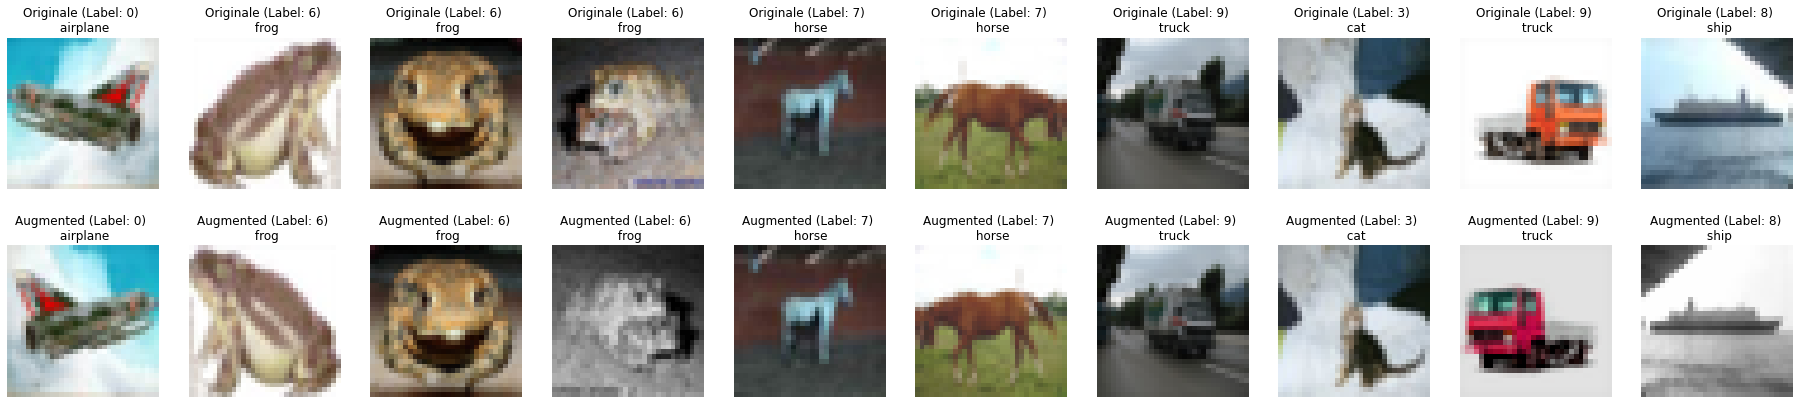

-------------------------------------------------------------
Epoch 1/100


100%|██████████| 750/750 [00:12<00:00, 61.09it/s]



    Train Loss: 15.6064

    Test Loss: 13.7994
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 2/100


100%|██████████| 750/750 [00:12<00:00, 61.01it/s]



    Train Loss: 8.0529

    Test Loss: 6.5207
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 3/100


100%|██████████| 750/750 [00:12<00:00, 60.54it/s]



    Train Loss: 4.4589

    Test Loss: 5.1898
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 4/100


100%|██████████| 750/750 [00:12<00:00, 61.18it/s]



    Train Loss: 3.304

    Test Loss: 3.4057
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 5/100


100%|██████████| 750/750 [00:14<00:00, 50.74it/s]



    Train Loss: 2.4449

    Test Loss: 2.9064
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 6/100


100%|██████████| 750/750 [00:12<00:00, 61.62it/s]



    Train Loss: 2.2246

    Test Loss: 2.7585
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 7/100


100%|██████████| 750/750 [00:12<00:00, 61.47it/s]



    Train Loss: 2.0153

    Test Loss: 2.5928
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 8/100


100%|██████████| 750/750 [00:12<00:00, 61.34it/s]



    Train Loss: 2.0188

    Test Loss: 2.8331
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 9/100


100%|██████████| 750/750 [00:12<00:00, 60.97it/s]



    Train Loss: 1.9402

    Test Loss: 2.7235
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 10/100


100%|██████████| 750/750 [00:12<00:00, 60.77it/s]



    Train Loss: 1.9315

    Test Loss: 2.7825
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 11/100


100%|██████████| 750/750 [00:12<00:00, 61.30it/s]



    Train Loss: 1.729

    Test Loss: 2.4501
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 12/100


100%|██████████| 750/750 [00:12<00:00, 61.73it/s]



    Train Loss: 1.678

    Test Loss: 2.43
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 13/100


100%|██████████| 750/750 [00:12<00:00, 61.39it/s]



    Train Loss: 1.687

    Test Loss: 2.5993
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 14/100


100%|██████████| 750/750 [00:12<00:00, 60.81it/s]



    Train Loss: 1.6643

    Test Loss: 2.6761
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 15/100


100%|██████████| 750/750 [00:12<00:00, 60.14it/s]



    Train Loss: 1.5366

    Test Loss: 2.3943
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 16/100


100%|██████████| 750/750 [00:13<00:00, 56.15it/s]



    Train Loss: 1.3066

    Test Loss: 2.355
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 17/100


100%|██████████| 750/750 [00:12<00:00, 60.97it/s]



    Train Loss: 1.2966

    Test Loss: 2.3364
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 18/100


100%|██████████| 750/750 [00:12<00:00, 60.88it/s]



    Train Loss: 1.2357

    Test Loss: 2.4071
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 19/100


100%|██████████| 750/750 [00:12<00:00, 60.69it/s]



    Train Loss: 1.1457

    Test Loss: 2.2957
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 20/100


100%|██████████| 750/750 [00:12<00:00, 60.68it/s]



    Train Loss: 1.061

    Test Loss: 2.3486
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 21/100


100%|██████████| 750/750 [00:12<00:00, 61.18it/s]



    Train Loss: 0.9779

    Test Loss: 2.3608
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 22/100


100%|██████████| 750/750 [00:12<00:00, 61.43it/s]



    Train Loss: 0.9246

    Test Loss: 2.3077
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 23/100


100%|██████████| 750/750 [00:12<00:00, 60.49it/s]



    Train Loss: 0.7916

    Test Loss: 2.4369
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 24/100


100%|██████████| 750/750 [00:12<00:00, 61.55it/s]



    Train Loss: 0.782

    Test Loss: 2.2919
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 25/100


100%|██████████| 750/750 [00:12<00:00, 61.60it/s]



    Train Loss: 0.6414

    Test Loss: 2.3043
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 26/100


100%|██████████| 750/750 [00:14<00:00, 50.71it/s]



    Train Loss: 0.5542

    Test Loss: 2.336
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 27/100


100%|██████████| 750/750 [00:12<00:00, 60.35it/s]



    Train Loss: 0.5731

    Test Loss: 2.4098
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 28/100


100%|██████████| 750/750 [00:12<00:00, 61.32it/s]



    Train Loss: 0.4844

    Test Loss: 2.353
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 29/100


100%|██████████| 750/750 [00:12<00:00, 61.33it/s]



    Train Loss: 0.4042

    Test Loss: 2.416
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 30/100


100%|██████████| 750/750 [00:12<00:00, 60.54it/s]



    Train Loss: 0.4296

    Test Loss: 2.4711
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 31/100


100%|██████████| 750/750 [00:12<00:00, 60.63it/s]



    Train Loss: 0.4385

    Test Loss: 2.4263
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 32/100


100%|██████████| 750/750 [00:12<00:00, 59.50it/s]



    Train Loss: 0.3795

    Test Loss: 2.4401
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 33/100


100%|██████████| 750/750 [00:12<00:00, 60.70it/s]



    Train Loss: 0.328

    Test Loss: 2.4539
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 34/100


100%|██████████| 750/750 [00:12<00:00, 60.33it/s]



    Train Loss: 0.3054

    Test Loss: 2.5403
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 35/100


100%|██████████| 750/750 [00:12<00:00, 61.43it/s]



    Train Loss: 0.2531

    Test Loss: 2.5591
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 36/100


100%|██████████| 750/750 [00:14<00:00, 50.63it/s]



    Train Loss: 0.2976

    Test Loss: 2.6043
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 37/100


100%|██████████| 750/750 [00:12<00:00, 61.35it/s]



    Train Loss: 0.2435

    Test Loss: 2.5645
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 38/100


100%|██████████| 750/750 [00:12<00:00, 60.76it/s]



    Train Loss: 0.2588

    Test Loss: 2.5488
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 39/100


100%|██████████| 750/750 [00:12<00:00, 61.03it/s]



    Train Loss: 0.2417

    Test Loss: 2.5426
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 40/100


100%|██████████| 750/750 [00:12<00:00, 61.23it/s]



    Train Loss: 0.2326

    Test Loss: 2.6399
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 41/100


100%|██████████| 750/750 [00:12<00:00, 60.99it/s]



    Train Loss: 0.2003

    Test Loss: 2.7003
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 42/100


100%|██████████| 750/750 [00:12<00:00, 61.29it/s]



    Train Loss: 0.1908

    Test Loss: 2.6745
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 43/100


100%|██████████| 750/750 [00:12<00:00, 61.12it/s]



    Train Loss: 0.1728

    Test Loss: 2.812
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 44/100


100%|██████████| 750/750 [00:12<00:00, 61.20it/s]



    Train Loss: 0.1523

    Test Loss: 2.7239
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 45/100


100%|██████████| 750/750 [00:12<00:00, 60.28it/s]



    Train Loss: 0.1315

    Test Loss: 2.7561
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 46/100


100%|██████████| 750/750 [00:12<00:00, 59.51it/s]



    Train Loss: 0.1583

    Test Loss: 2.8236
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 47/100


100%|██████████| 750/750 [00:13<00:00, 56.58it/s]



    Train Loss: 0.1966

    Test Loss: 2.8505
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 48/100


100%|██████████| 750/750 [00:12<00:00, 61.44it/s]



    Train Loss: 0.1718

    Test Loss: 2.8632
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 49/100


100%|██████████| 750/750 [00:12<00:00, 61.00it/s]



    Train Loss: 0.1278

    Test Loss: 2.7595
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 50/100


100%|██████████| 750/750 [00:12<00:00, 60.79it/s]



    Train Loss: 0.1474

    Test Loss: 2.8563
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 51/100


100%|██████████| 750/750 [00:12<00:00, 61.51it/s]



    Train Loss: 0.1648

    Test Loss: 2.7914
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 52/100


100%|██████████| 750/750 [00:12<00:00, 61.05it/s]



    Train Loss: 0.1314

    Test Loss: 2.8481
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 53/100


100%|██████████| 750/750 [00:12<00:00, 61.36it/s]



    Train Loss: 0.167

    Test Loss: 2.7651
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 54/100


100%|██████████| 750/750 [00:12<00:00, 61.22it/s]



    Train Loss: 0.1212

    Test Loss: 2.7805
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 55/100


100%|██████████| 750/750 [00:12<00:00, 60.86it/s]



    Train Loss: 0.0965

    Test Loss: 2.8724
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 56/100


100%|██████████| 750/750 [00:12<00:00, 60.35it/s]



    Train Loss: 0.1319

    Test Loss: 2.8064
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 57/100


100%|██████████| 750/750 [00:14<00:00, 50.99it/s]



    Train Loss: 0.1523

    Test Loss: 2.8872
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 58/100


100%|██████████| 750/750 [00:12<00:00, 60.54it/s]



    Train Loss: 0.0932

    Test Loss: 2.9194
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 59/100


100%|██████████| 750/750 [00:12<00:00, 61.56it/s]



    Train Loss: 0.0792

    Test Loss: 2.7452
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 60/100


100%|██████████| 750/750 [00:12<00:00, 61.84it/s]



    Train Loss: 0.1004

    Test Loss: 2.8814
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 61/100


100%|██████████| 750/750 [00:12<00:00, 60.34it/s]



    Train Loss: 0.1512

    Test Loss: 2.8161
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 62/100


100%|██████████| 750/750 [00:12<00:00, 60.67it/s]



    Train Loss: 0.1006

    Test Loss: 2.8393
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 63/100


100%|██████████| 750/750 [00:12<00:00, 61.24it/s]



    Train Loss: 0.1132

    Test Loss: 2.849
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 64/100


100%|██████████| 750/750 [00:12<00:00, 61.62it/s]



    Train Loss: 0.0834

    Test Loss: 2.8777
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 65/100


100%|██████████| 750/750 [00:12<00:00, 61.10it/s]



    Train Loss: 0.1129

    Test Loss: 2.9246
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 66/100


100%|██████████| 750/750 [00:12<00:00, 60.82it/s]



    Train Loss: 0.1233

    Test Loss: 2.9465
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 67/100


100%|██████████| 750/750 [00:12<00:00, 58.06it/s]



    Train Loss: 0.1143

    Test Loss: 2.9333
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 68/100


100%|██████████| 750/750 [00:13<00:00, 57.07it/s]



    Train Loss: 0.1126

    Test Loss: 2.8193
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 69/100


100%|██████████| 750/750 [00:12<00:00, 61.23it/s]



    Train Loss: 0.0692

    Test Loss: 2.87
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 70/100


100%|██████████| 750/750 [00:12<00:00, 61.30it/s]



    Train Loss: 0.0882

    Test Loss: 2.9108
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 71/100


100%|██████████| 750/750 [00:12<00:00, 61.24it/s]



    Train Loss: 0.0734

    Test Loss: 2.8388
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 72/100


100%|██████████| 750/750 [00:12<00:00, 60.38it/s]



    Train Loss: 0.0694

    Test Loss: 2.8476
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 73/100


100%|██████████| 750/750 [00:12<00:00, 61.15it/s]



    Train Loss: 0.0848

    Test Loss: 2.9775
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 74/100


100%|██████████| 750/750 [00:12<00:00, 60.87it/s]



    Train Loss: 0.0553

    Test Loss: 2.9434
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 75/100


100%|██████████| 750/750 [00:12<00:00, 61.10it/s]



    Train Loss: 0.0804

    Test Loss: 2.9801
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 76/100


100%|██████████| 750/750 [00:12<00:00, 61.26it/s]



    Train Loss: 0.0562

    Test Loss: 3.0376
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 77/100


100%|██████████| 750/750 [00:12<00:00, 60.34it/s]



    Train Loss: 0.0879

    Test Loss: 3.0718
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 78/100


100%|██████████| 750/750 [00:15<00:00, 49.95it/s]



    Train Loss: 0.0751

    Test Loss: 3.0834
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 79/100


100%|██████████| 750/750 [00:12<00:00, 59.71it/s]



    Train Loss: 0.0602

    Test Loss: 3.023
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 80/100


100%|██████████| 750/750 [00:12<00:00, 59.06it/s]



    Train Loss: 0.0682

    Test Loss: 2.9795
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 81/100


100%|██████████| 750/750 [00:12<00:00, 58.43it/s]



    Train Loss: 0.0675

    Test Loss: 2.9985
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 82/100


100%|██████████| 750/750 [00:12<00:00, 59.05it/s]



    Train Loss: 0.0565

    Test Loss: 3.071
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 83/100


100%|██████████| 750/750 [00:12<00:00, 59.31it/s]



    Train Loss: 0.0649

    Test Loss: 2.9568
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 84/100


100%|██████████| 750/750 [00:12<00:00, 60.01it/s]



    Train Loss: 0.0611

    Test Loss: 2.9807
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 85/100


100%|██████████| 750/750 [00:12<00:00, 59.90it/s]



    Train Loss: 0.049

    Test Loss: 3.0382
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 86/100


100%|██████████| 750/750 [00:12<00:00, 60.77it/s]



    Train Loss: 0.0414

    Test Loss: 3.02
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 87/100


100%|██████████| 750/750 [00:12<00:00, 60.26it/s]



    Train Loss: 0.0603

    Test Loss: 3.0073
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 88/100


100%|██████████| 750/750 [00:14<00:00, 50.33it/s]



    Train Loss: 0.0631

    Test Loss: 3.0383
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 89/100


100%|██████████| 750/750 [00:12<00:00, 60.05it/s]



    Train Loss: 0.057

    Test Loss: 3.0038
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 90/100


100%|██████████| 750/750 [00:12<00:00, 60.75it/s]



    Train Loss: 0.0333

    Test Loss: 2.9982
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 91/100


100%|██████████| 750/750 [00:12<00:00, 59.65it/s]



    Train Loss: 0.0537

    Test Loss: 3.0335
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 92/100


100%|██████████| 750/750 [00:12<00:00, 58.20it/s]



    Train Loss: 0.0459

    Test Loss: 3.1171
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 93/100


100%|██████████| 750/750 [00:12<00:00, 60.24it/s]



    Train Loss: 0.0604

    Test Loss: 3.0803
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 94/100


100%|██████████| 750/750 [00:12<00:00, 59.95it/s]



    Train Loss: 0.0332

    Test Loss: 3.0307
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 95/100


100%|██████████| 750/750 [00:12<00:00, 60.40it/s]



    Train Loss: 0.0493

    Test Loss: 3.0442
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 96/100


100%|██████████| 750/750 [00:12<00:00, 59.41it/s]



    Train Loss: 0.0438

    Test Loss: 3.0107
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 97/100


100%|██████████| 750/750 [00:12<00:00, 60.18it/s]



    Train Loss: 0.0389

    Test Loss: 3.0581
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 98/100


100%|██████████| 750/750 [00:13<00:00, 56.23it/s]



    Train Loss: 0.0544

    Test Loss: 3.0657
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 99/100


100%|██████████| 750/750 [00:12<00:00, 57.75it/s]



    Train Loss: 0.0305

    Test Loss: 3.0693
------------------------------------------------------------- 

-------------------------------------------------------------
Epoch 100/100


100%|██████████| 750/750 [00:12<00:00, 59.77it/s]



    Train Loss: 0.0557

    Test Loss: 3.0715
------------------------------------------------------------- 

       recall  precision  f1_score  thresholds     class
0    1.000000   0.100000  0.181818        0.00  airplane
1    0.598333   0.312446  0.410520        0.05  airplane
2    0.527500   0.359864  0.427847        0.10  airplane
3    0.489167   0.394224  0.436594        0.15  airplane
4    0.461667   0.415916  0.437599        0.20  airplane
..        ...        ...       ...         ...       ...
205  0.276667   0.414482  0.331834        0.80     truck
206  0.248333   0.426934  0.314015        0.85     truck
207  0.213333   0.448336  0.289102        0.90     truck
208  0.152500   0.466837  0.229899        0.95     truck
209  0.000000   1.000000  0.000000        1.00     truck

[210 rows x 5 columns]


Test Global Accuracy:,▁▂▃▄▄▅▆▆▇▇▇▇▇▇▇████▇▇███████████████████
Test loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Unweighted Test F1_score,▁▂▄▄▅▅▆▆▇▇▇▇▇▇█████▇▇███████████████████
Unweighted Test MIou,▁▂▃▄▅▅▆▆▇▇▇▇▇▇████▇▇▇███████████████████
Unweighted Test Precision,▁▃▅▅▆▆▆▆▇▇▇▇▇▇█████▇▇██████▇██▇▇████████
Unweighted Test Recall,▁▂▃▄▄▅▆▆▇▇▇▇▇▇▇████▇▇███████████████████
Weighted Test F1_score,▁▂▄▄▅▅▆▆▇▇▇▇▇▇█████▇▇███████████████████
Weighted Test MIou,▁▂▃▄▅▅▆▆▇▇▇▇▇▇████▇▇▇███████████████████
Weighted Test Precision,▁▃▅▅▆▆▆▆▇▇▇▇▇▇█████▇▇██████▇██▇▇████████
Weighted Test Recall,▁▂▃▄▄▅▆▆▇▇▇▇▇▇▇████▇▇███████████████████


In [ ]:
run_ss_experiment(train_size=0.01)
run_randominit_experiment(train_size=0.01)

In [ ]:
run_ss_experiment(train_size=0.05)
run_randominit_experiment(train_size=0.05)

In [ ]:
run_ss_experiment(train_size=0.1)
run_randominit_experiment(train_size=0.1)